In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import xgboost

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

def classification_metrics(Y_pred, Y_true):
    acc = accuracy_score(Y_true, Y_pred)
    precision = precision_score(Y_true, Y_pred)
    recall = recall_score(Y_true, Y_pred)
    f1score = f1_score(Y_true, Y_pred)
    auc = roc_auc_score(Y_true, Y_pred)

    return acc, precision, recall, f1score, auc

def display_metrics(classifierName,Y_pred,Y_true):
    print ("______________________________________________")
    print ("Model: "+classifierName)
    acc, precision, recall, f1score, auc = classification_metrics(Y_pred,Y_true)
    print ("Accuracy: "+str(acc))
    print ("Precision: "+str(precision))
    print ("Recall: "+str(recall))
    print ("F1-score: "+str(f1score))
    print ("AUC: "+str(auc))
    print ("______________________________________________")
    print ("")

# Data preparation

In [2]:
df = pd.concat(
    [
        pd.read_csv('customer_churn_dataset-training-master.csv'), 
        pd.read_csv('customer_churn_dataset-testing-master.csv')
    ], 
    axis=0)
df.reset_index(drop=True, inplace=True)
df

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
505202,64370.0,45.0,Female,33.0,12.0,6.0,21.0,Basic,Quarterly,947.0,14.0,1.0
505203,64371.0,37.0,Male,6.0,1.0,5.0,22.0,Standard,Annual,923.0,9.0,1.0
505204,64372.0,25.0,Male,39.0,14.0,8.0,30.0,Premium,Monthly,327.0,20.0,1.0
505205,64373.0,50.0,Female,18.0,19.0,7.0,22.0,Standard,Monthly,540.0,13.0,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505207 entries, 0 to 505206
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         505206 non-null  float64
 1   Age                505206 non-null  float64
 2   Gender             505206 non-null  object 
 3   Tenure             505206 non-null  float64
 4   Usage Frequency    505206 non-null  float64
 5   Support Calls      505206 non-null  float64
 6   Payment Delay      505206 non-null  float64
 7   Subscription Type  505206 non-null  object 
 8   Contract Length    505206 non-null  object 
 9   Total Spend        505206 non-null  float64
 10  Last Interaction   505206 non-null  float64
 11  Churn              505206 non-null  float64
dtypes: float64(9), object(3)
memory usage: 46.3+ MB


In [4]:
for column in df:
    if df[column].dtypes=='object':
        print(f'{column}: {df[column].unique()}')

Gender: ['Female' 'Male' nan]
Subscription Type: ['Standard' 'Basic' 'Premium' nan]
Contract Length: ['Annual' 'Monthly' 'Quarterly' nan]


In [5]:
df.describe(include=[object]) 

,Gender,Subscription Type,Contract Length
count,505206,505206,505206
unique,2,3,3
top,Male,Standard,Annual
freq,280273,170630,198608


In [6]:
df.drop(columns='CustomerID', inplace=True)
df.columns = [col.replace(' ', '_') for col in df.columns]

In [7]:
df.shape

(505207, 11)

In [8]:
df.isnull().sum()

Age                  1
Gender               1
Tenure               1
Usage_Frequency      1
Support_Calls        1
Payment_Delay        1
Subscription_Type    1
Contract_Length      1
Total_Spend          1
Last_Interaction     1
Churn                1
dtype: int64

In [9]:
df[df.isna().any(axis=1)]

,Age,Gender,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Subscription_Type,Contract_Length,Total_Spend,Last_Interaction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.dropna(inplace=True)

In [11]:
df = df.reset_index(drop = True)
df

,Age,Gender,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Subscription_Type,Contract_Length,Total_Spend,Last_Interaction,Churn
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
505201,45.0,Female,33.0,12.0,6.0,21.0,Basic,Quarterly,947.0,14.0,1.0
505202,37.0,Male,6.0,1.0,5.0,22.0,Standard,Annual,923.0,9.0,1.0
505203,25.0,Male,39.0,14.0,8.0,30.0,Premium,Monthly,327.0,20.0,1.0
505204,50.0,Female,18.0,19.0,7.0,22.0,Standard,Monthly,540.0,13.0,1.0


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,505206.0,39.704172,12.670577,18.0,29.0,40.0,49.0,65.0
Tenure,505206.0,31.350435,17.237482,1.0,16.0,32.0,46.0,60.0
Usage_Frequency,505206.0,15.714825,8.619323,1.0,8.0,16.0,23.0,30.0
Support_Calls,505206.0,3.833317,3.133603,0.0,1.0,3.0,6.0,10.0
Payment_Delay,505206.0,13.496843,8.451187,0.0,6.0,13.0,20.0,30.0
Total_Spend,505206.0,620.072766,245.319256,100.0,446.0,648.9,824.0,1000.0
Last_Interaction,505206.0,14.610581,8.608286,1.0,7.0,14.0,22.0,30.0
Churn,505206.0,0.555203,0.496944,0.0,0.0,1.0,1.0,1.0


# Exploratory Data Analysis (EDA)

# Correlation between features except for the Churn rate

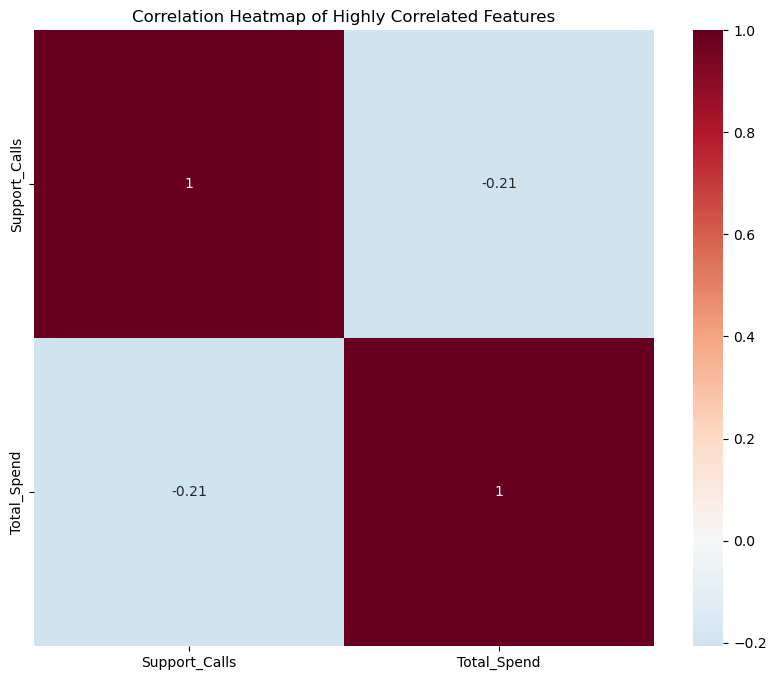

In [13]:
corr_matrix = df.drop(columns=['Churn']).corr(numeric_only=True)

high_corr_features = []
for column in corr_matrix.columns:
    max_corr = corr_matrix[column].drop(index=column).abs().max()
    if max_corr > 0.2:
        high_corr_features.append(column)

plt.figure(figsize=(10, 8))
sns.heatmap(df[high_corr_features].corr(), annot=True, cmap='RdBu_r', center=0)
plt.title('Correlation Heatmap of Highly Correlated Features')
plt.show()

# Target Variable Analysis – Churn rate

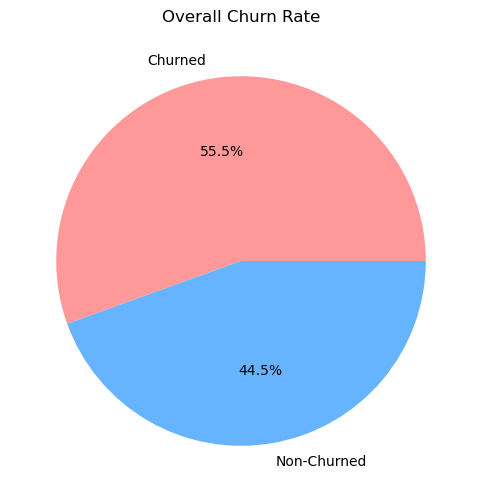

In [14]:
overall_churn_rate = df['Churn'].mean() * 100

plt.figure(figsize=(6, 6))
plt.pie([overall_churn_rate, 100 - overall_churn_rate], labels=['Churned', 'Non-Churned'], autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
plt.title('Overall Churn Rate')
plt.show()

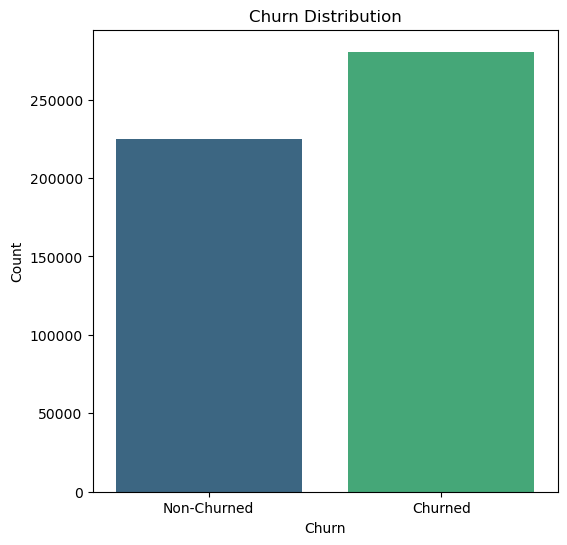

In [15]:
plt.figure(figsize=(6, 6))
sns.countplot(data=df, x='Churn', palette='viridis')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Churn Distribution')
plt.xticks([0, 1], ['Non-Churned', 'Churned'])
plt.show()

# Correlation between different features and the Churn rate

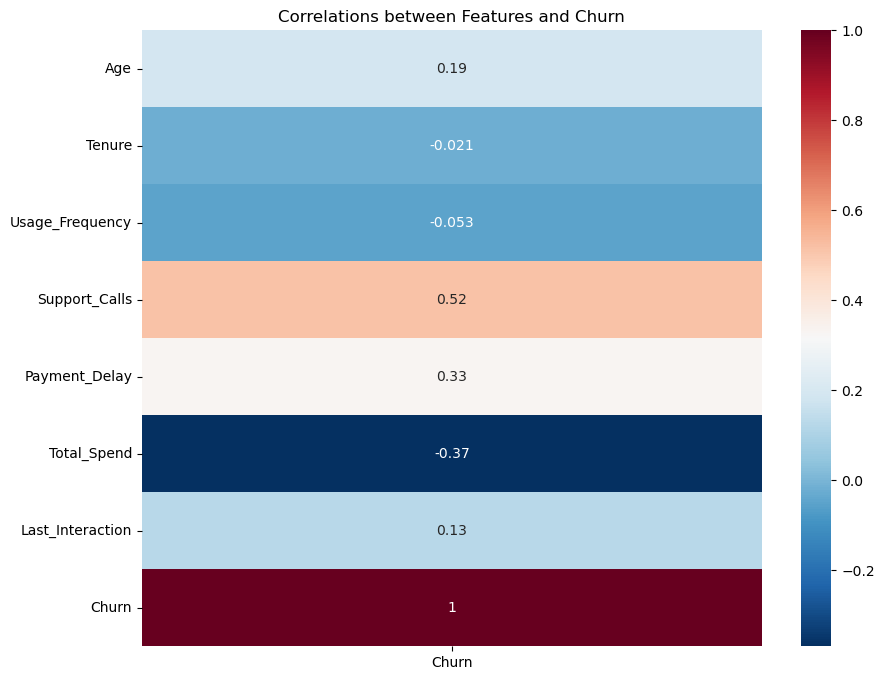

In [16]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['Churn']], annot=True, cmap='RdBu_r')
plt.title('Correlations between Features and Churn')
plt.show()

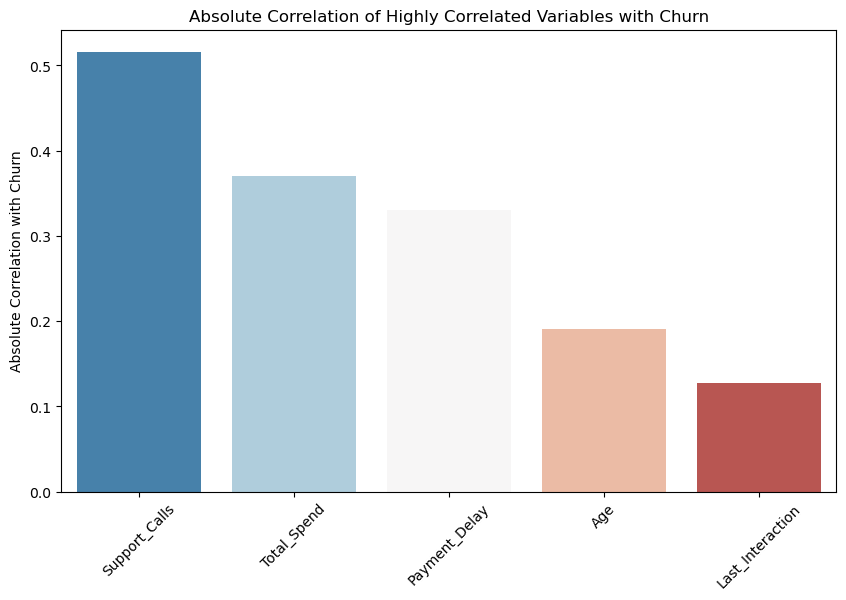

In [17]:
high_corr_vars = corr_matrix.abs().nlargest(6, 'Churn')['Churn'].index[1:]
high_corr_values = corr_matrix.abs().nlargest(6, 'Churn')['Churn'].values[1:]

plt.figure(figsize=(10, 6))
sns.barplot(x=high_corr_vars, y=high_corr_values, palette='RdBu_r')
plt.ylabel('Absolute Correlation with Churn')
plt.title('Absolute Correlation of Highly Correlated Variables with Churn')
plt.xticks(rotation=45)
plt.show()

# Support calls and Churn rate

In [18]:
average_support_calls = df['Support_Calls'].mean()
print(f"Average Number of Support Calls: {average_support_calls}")

Average Number of Support Calls: 3.8333174982086513


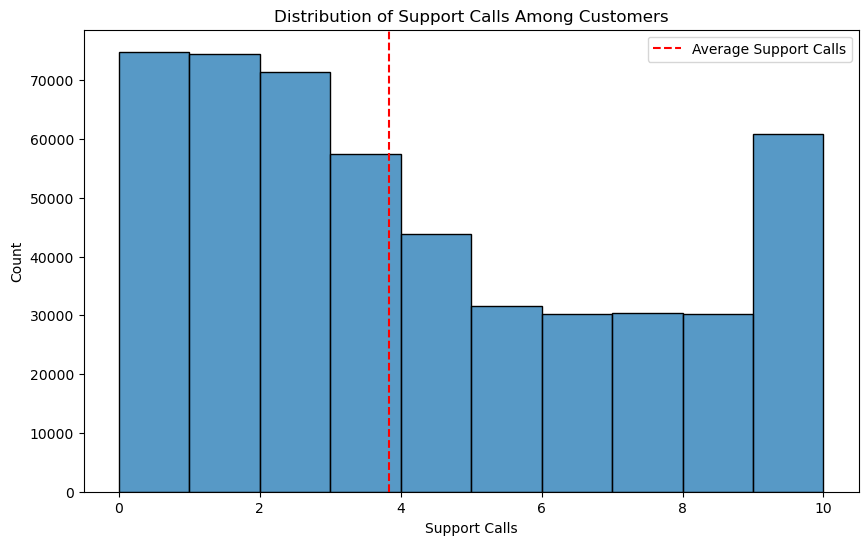

In [19]:
plt.figure(figsize = (10,6))
sns.histplot(data = df , x = 'Support_Calls' , bins = 10  )
plt.axvline(average_support_calls, color='red', linestyle='dashed', label='Average Support Calls')
plt.xlabel('Support Calls')
plt.ylabel('Count')
plt.title('Distribution of Support Calls Among Customers')
plt.legend()
plt.show()

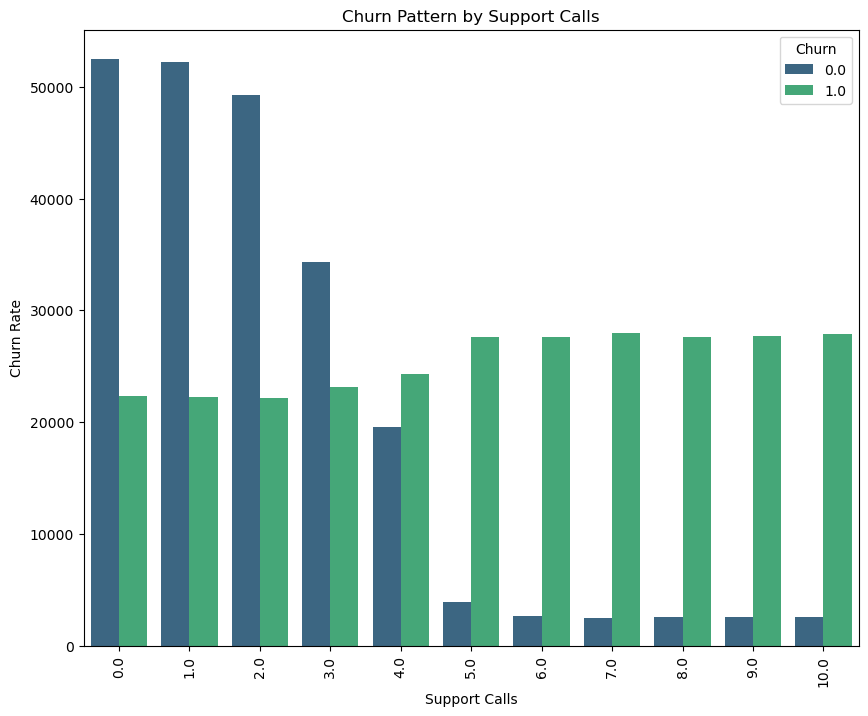

In [20]:
plt.figure(figsize = (10,8))
sns.countplot(data = df , x = 'Support_Calls' , hue = 'Churn', palette = 'viridis')
plt.xlabel('Support Calls')
plt.ylabel('Churn Rate')
plt.title('Churn Pattern by Support Calls')
plt.xticks(rotation=90)
plt.show()

# Total spend and Churn rate

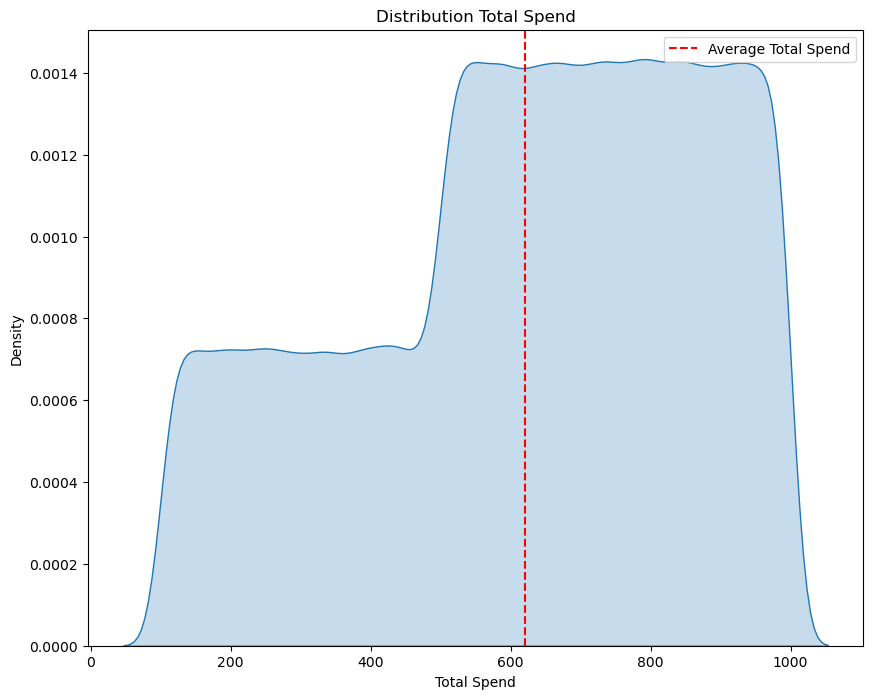

In [21]:
plt.figure(figsize = (10,8))
sns.kdeplot(data = df , x = 'Total_Spend' , fill = True )
plt.title('Distribution Total Spend')
avg_total_spend = df.Total_Spend.mean()
plt.xlabel('Total Spend')
plt.axvline(avg_total_spend , color = 'red' , linestyle = 'dashed' , label = 'Average Total Spend')
plt.legend()
plt.show()

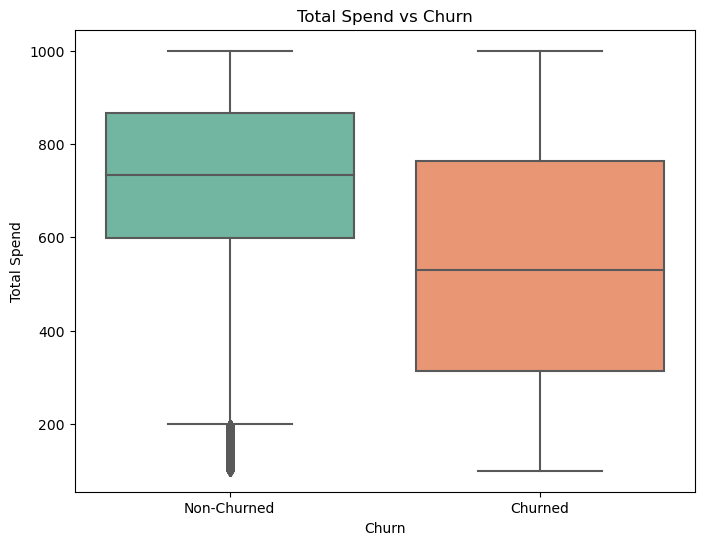

In [22]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='Total_Spend', data=df, palette='Set2')
plt.xlabel('Churn')
plt.ylabel('Total Spend')
plt.title('Total Spend vs Churn')
plt.xticks([0, 1], ['Non-Churned', 'Churned'])
plt.show()

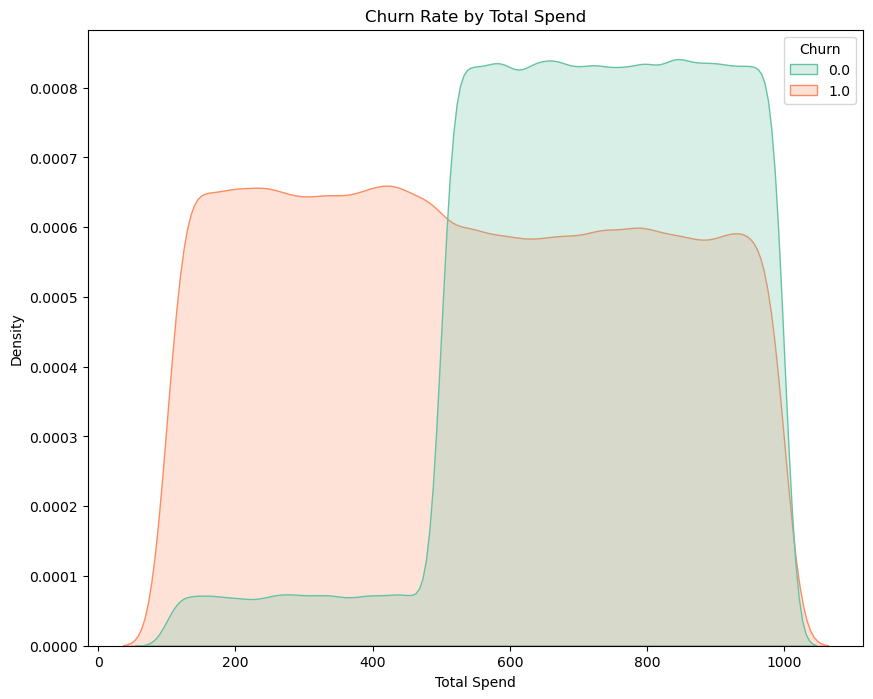

In [23]:
plt.figure(figsize = (10,8))
sns.kdeplot(data = df , x = 'Total_Spend' ,hue = 'Churn', fill = True , palette = 'Set2')
plt.title('Churn Rate by Total Spend')
plt.xlabel('Total Spend')
plt.show()

# Payment delay and Churn rate

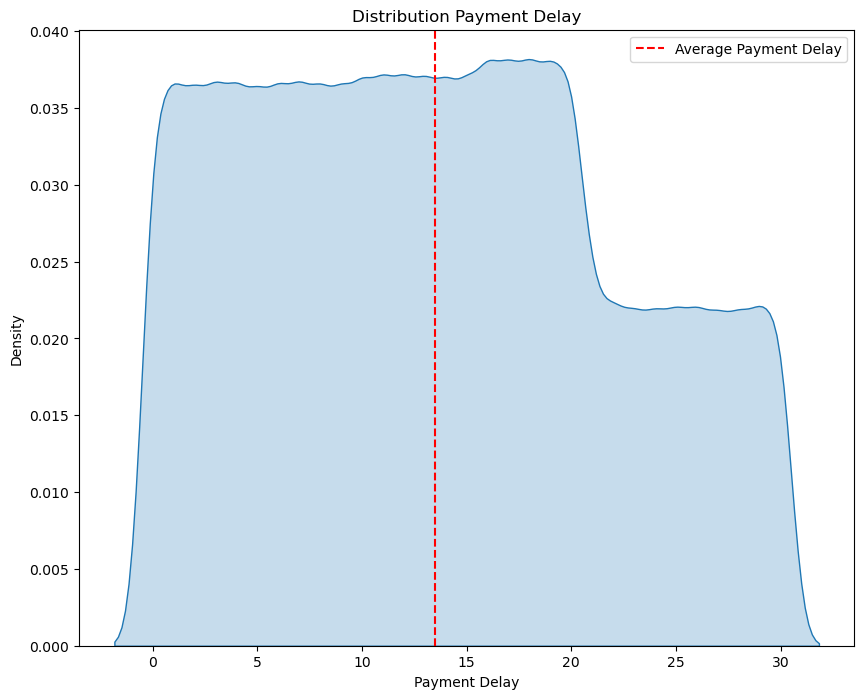

In [24]:
plt.figure(figsize = (10,8))
sns.kdeplot(data = df , x = 'Payment_Delay' , fill = True)
plt.title('Distribution Payment Delay')
avg_payment_delay = df.Payment_Delay.mean()
plt.xlabel('Payment Delay')
plt.axvline(avg_payment_delay , color = 'red' , linestyle = 'dashed' , label = 'Average Payment Delay')
plt.legend()
plt.show()

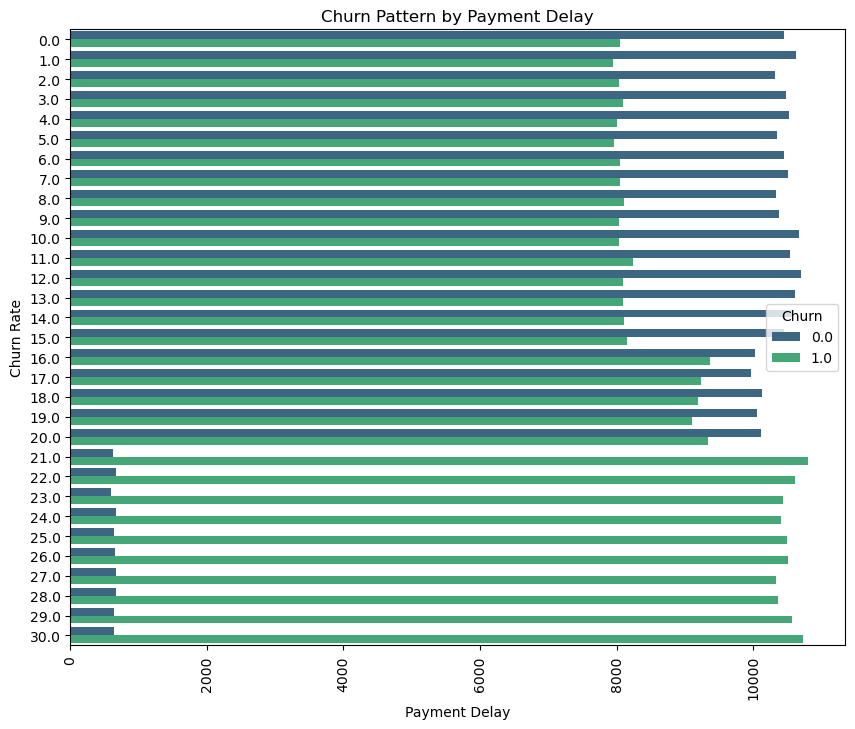

In [25]:
plt.figure(figsize = (10,8))
sns.countplot(data = df , y = 'Payment_Delay' , hue = 'Churn', palette = 'viridis')
plt.xlabel('Payment Delay')
plt.ylabel('Churn Rate')
plt.title('Churn Pattern by Payment Delay')
plt.xticks(rotation=90)
plt.show()

# Age distribution and Churn rate

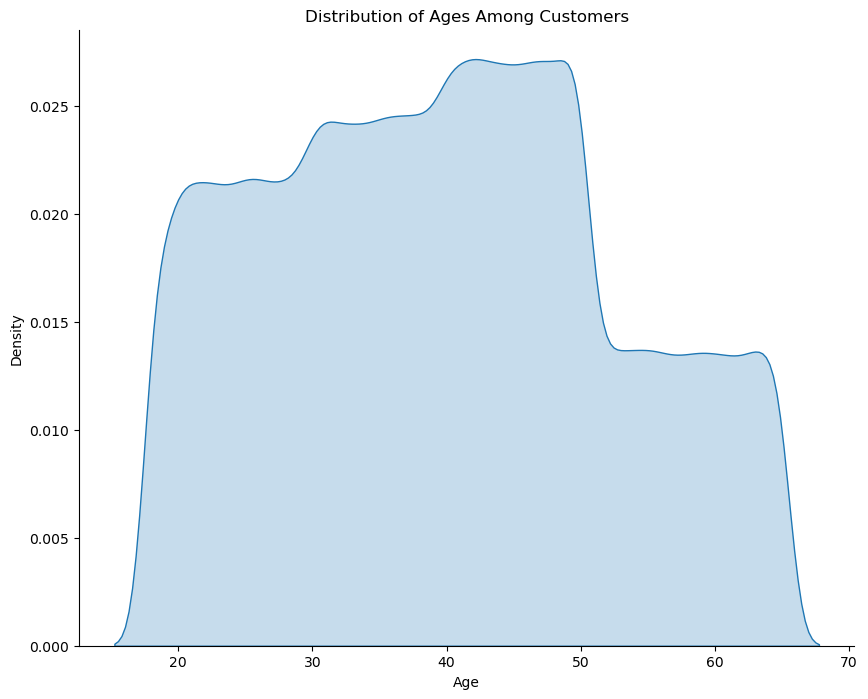

In [26]:
plt.figure(figsize=(10,8))
sns.kdeplot(data = df, x = df['Age'], fill = True, common_norm=False)
plt.title('Distribution of Ages Among Customers')
sns.despine()
plt.show()

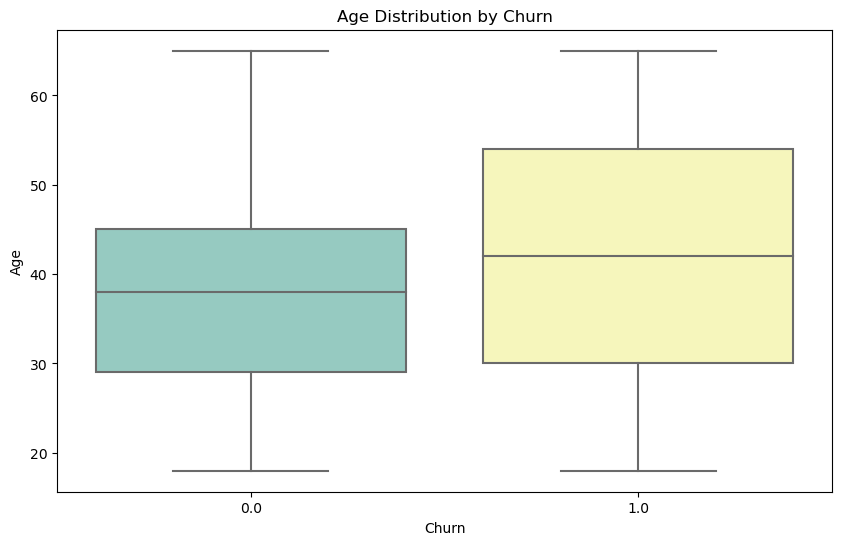

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='Age', data=df, palette='Set3')
plt.xlabel('Churn')
plt.ylabel('Age')
plt.title('Age Distribution by Churn')
plt.show()

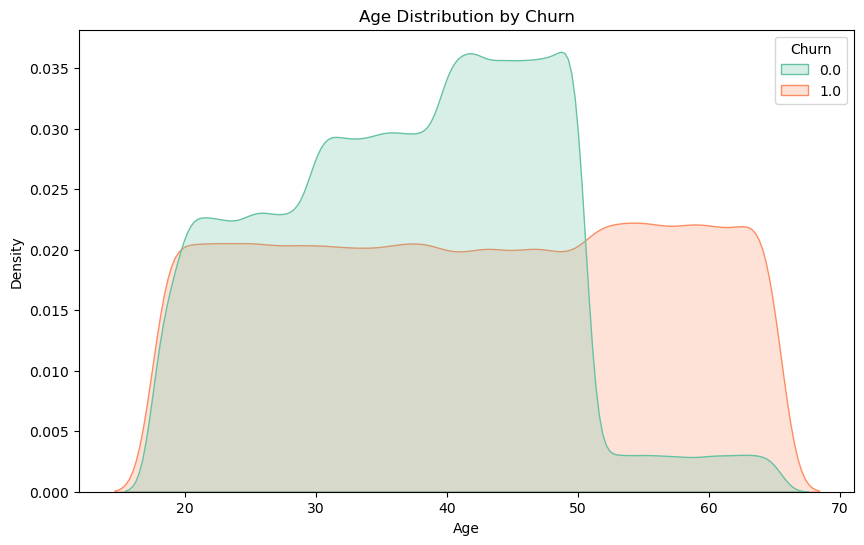

In [28]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Age', hue='Churn', common_norm=False, fill=True, palette='Set2')
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution by Churn')
plt.show()

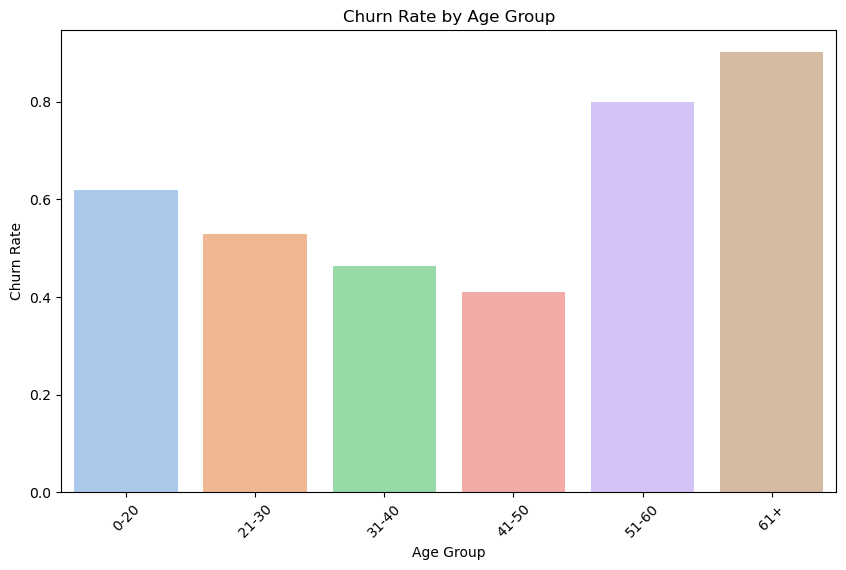

In [29]:
age_bins = [0, 20, 30, 40, 50, 60, float('inf')]
age_labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61+']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)
age_churn_rate = df.groupby('AgeGroup')['Churn'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=age_churn_rate.index, y=age_churn_rate.values, palette='pastel')
plt.xlabel('Age Group')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Age Group')
plt.xticks(rotation=45)
plt.show()

# Last interaction and Churn rate

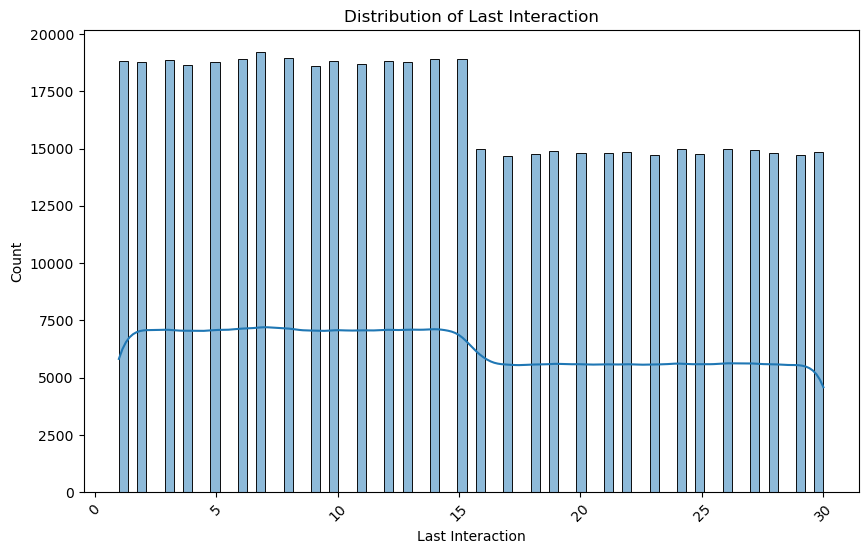

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Last_Interaction', kde=True)
plt.xlabel('Last Interaction')
plt.ylabel('Count')
plt.title('Distribution of Last Interaction')
plt.xticks(rotation=45)
plt.show()

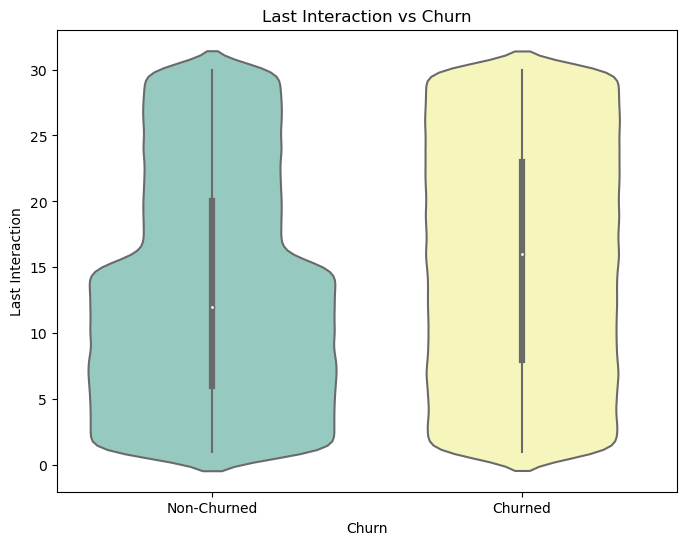

In [31]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='Churn', y='Last_Interaction', data=df, palette='Set3')
plt.xlabel('Churn')
plt.ylabel('Last Interaction')
plt.title('Last Interaction vs Churn')
plt.xticks([0, 1], ['Non-Churned', 'Churned'])
plt.show()